# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Загрузка модулей

### Импорт модулей

In [1]:
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Настройки

In [2]:
RANDOM_STATE = 12345
state = np.random.RandomState(RANDOM_STATE)
# Цветовая палитра документа
cm = 'crest'
mec = 'gray'
alpha = 0.7
fontsize = 16
figsize_base = 5

def new_color(x='r'):
    '''Цвет графиков, по умолчанию случайный из заданной цветовой палитры. Принимает в качестве аргумента число, \
    соответствующее цвету в палитре.'''
    if x == 'r':
        return list(sns.color_palette(cm, 20)[random.randint(0,19)])
    return list(sns.color_palette(cm, 20)[x])
# Размеры

def figsize(width = 1, height=1):
    '''Задание размеров окна отрисовки.'''
    return (width*figsize_base, height*figsize_base)

# Отрисовка 
def plot_set(ax,title='',xlabel='',ylabel='',fontsize=fontsize,xrot=True,figsize=figsize()):
    '''Функция для отрисовки дополнительных параметров графиков. Подписьи осей и названия, размер шрифта и размер окна, 
    включение сетки.'''
    plt.xticks(rotation=90*int(xrot), fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.title(title+'\n', fontsize=fontsize)
    plt.xlabel('\n'+xlabel, fontsize=fontsize)
    plt.ylabel(ylabel+'\n', fontsize=fontsize)
    plt.grid(True)
    None
    
def mean_percent(x):
    '''Функция для форматирования значений. Округление до сотых и знак процента.'''
    try:
        return "{0:.2%}".format(x)
    except:
        return x

## Исследовательский анализ данных

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=RANDOM_STATE)

Found 7591 validated image filenames.


In [4]:
labels.shape

(7591, 2)

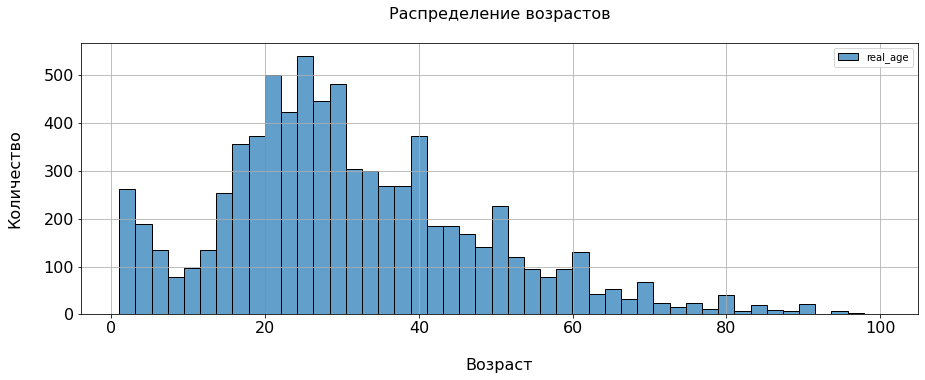

In [5]:
plt.figure(figsize=figsize(3))
ax = sns.histplot(labels,alpha=alpha,color=new_color())
plot_set(ax,title='Распределение возрастов',xlabel='Возраст', ylabel='Количество', xrot=False)
None

In [6]:
print(labels.describe())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


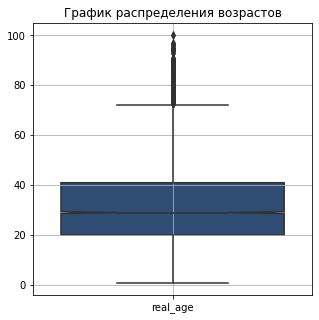

In [7]:
plt.figure(figsize=figsize())
sns.boxplot(data=labels,notch=True,color = new_color())
plt.title('График распределения возрастов')
plt.grid(True)

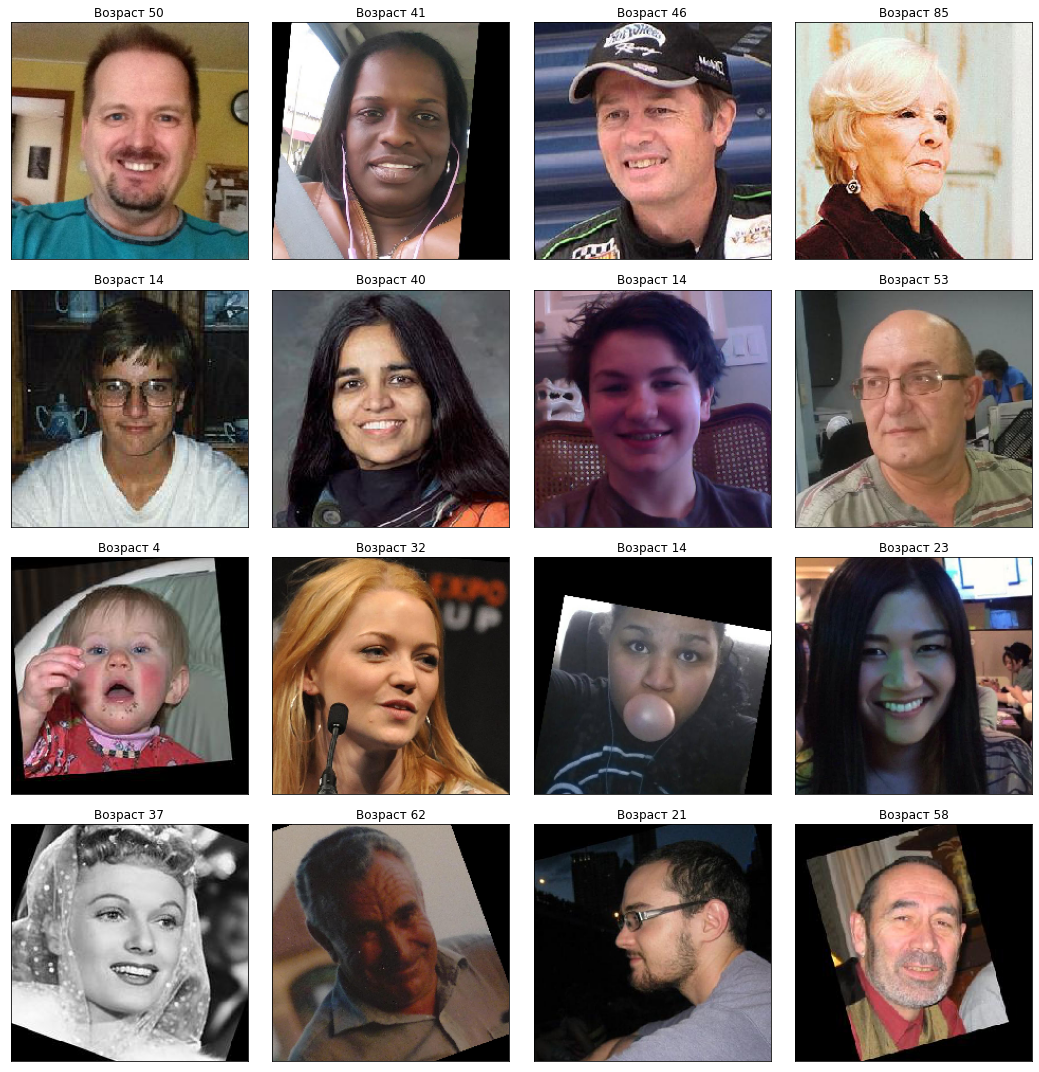

In [8]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=figsize(3,3))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.title(f'Возраст {target[i]}')
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод этапа

Датасет обладает 7591 фотографиями.

Больше всего фотографий в диапазоне от 16 до 42 лет. Также в выборке размечены дети и старики.

## Обучение модели

Обучим модель нейронной сети на GPU

```python
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow
    
def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

Результат:

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 64s - loss: 191.9105 - mae: 10.1182 - val_loss: 496.1500 - val_mae: 17.1332
Epoch 2/10
356/356 - 39s - loss: 66.7372 - mae: 6.1937 - val_loss: 120.5121 - val_mae: 8.5281
Epoch 3/10
356/356 - 38s - loss: 37.7569 - mae: 4.7253 - val_loss: 77.9079 - val_mae: 6.8526
Epoch 4/10
356/356 - 40s - loss: 26.3591 - mae: 3.9764 - val_loss: 89.5340 - val_mae: 7.3254
Epoch 5/10
356/356 - 41s - loss: 19.0169 - mae: 3.3859 - val_loss: 101.1727 - val_mae: 7.4978
Epoch 6/10
356/356 - 42s - loss: 14.1639 - mae: 2.8936 - val_loss: 70.7424 - val_mae: 6.3070
Epoch 7/10
356/356 - 40s - loss: 12.0765 - mae: 2.6543 - val_loss: 70.5561 - val_mae: 6.4777
Epoch 8/10
356/356 - 41s - loss: 9.8902 - mae: 2.3758 - val_loss: 69.3304 - val_mae: 6.2505
Epoch 9/10
356/356 - 41s - loss: 9.5445 - mae: 2.3448 - val_loss: 65.3204 - val_mae: 6.1547
Epoch 10/10
356/356 - 41s - loss: 9.6703 - mae: 2.3506 - val_loss: 62.9198 - val_mae: 5.9292
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 62.9198 - mae: 5.9292

```

Модель сверточной нейронной сети построена на ResNet50.

За 10 эпох обучения удалось уменьшить `MAE` с 10 до 2.3 на тренировочной выборке. На валидационной выборке `MAE` около 5.9.

## Анализ обученной модели

В результате проведенного исследования был загружен и проанализированы данные:

- общее количество 7591 изображений
    - 5694 для обучения
    - 1897 для валидации
- изображения имеют размер 256х256х3
- датафрейм с 2 колонками file_name (имя файла) и real_age (целевой признак, в формате int)
- на изображения разные люди возрастом от 0 до 100 лет
- возраст выше 75 лет в наших данных является редким

В работе использовалась нейросеть следующей архитектуры:
 - Слои:
    - ResNet50 в качестве основы (backbone): Предварительно обученная сверточная нейронная сеть с 50 слоями. Обучена на большом наборе изображений (ImageNet)
    - GlobalAveragePooling2D(): Преобразует выход ResNet50 в плоский вектор, усредняя значения по всему пространству признаков.
    - Полносвязный слой (Dense): Содержит 1 нейрон с функцией активации ReLU для генерации числового выхода.
    
- Оптимизатор и компиляция:
    - Оптимизатор Adam: Используется для обучения сети с заданной скоростью обучения (`learning rate` = 0.0001).
    - Функция потерь : Mean Squared Error.
    - Метрики: Mean Absolute Error.

Цель обучения нейросети достигнута. В результате выполнения кода, созданной нейросети на GPU с валидационными данными, получено значение показателя `MAE` равного 5.9. Это меньше целевого значания 8. Значеня на тестовой и валидационной выборках немного отличаются, значит модель немного переобучилась.

Данная модель рекомендуется для использования в сервисе, анализирующем покупки и предлагающем товары, которые могут заинтересовать покупателей разных возрастных групп. Модель не рекоммендуется для контроля добросовестности кассиров при продаже алкоголя, поскольку в данном вопросе даже разница в один год играет существенную роль. 